In [8]:
import sys
sys.path.append('../')  # Add the parent folder to the system path

from torchtext.vocab import GloVe

# Load pre-trained Word2Vec embeddings(GloVe)
word_embeddings = GloVe(name='6B', dim=100)

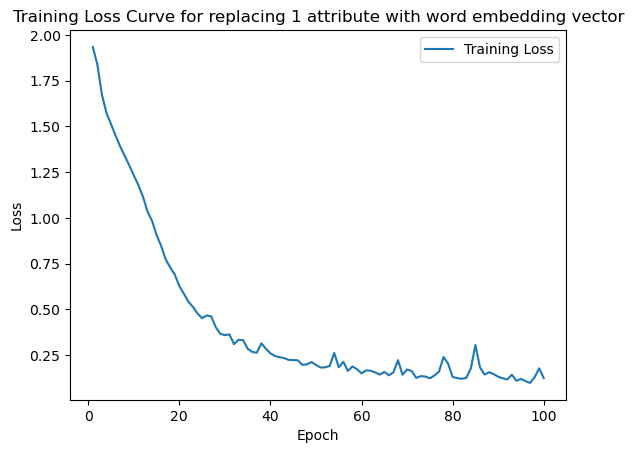


Test Accuracy: 0.9267

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8947    0.9444        57
           1     0.8909    0.8167    0.8522        60
           2     0.8154    0.8689    0.8413        61
           3     0.8679    0.9020    0.8846        51
           4     0.9315    1.0000    0.9645        68
           5     1.0000    0.9821    0.9910        56
           6     0.9859    1.0000    0.9929        70

    accuracy                         0.9267       423
   macro avg     0.9274    0.9235    0.9244       423
weighted avg     0.9286    0.9267    0.9267       423



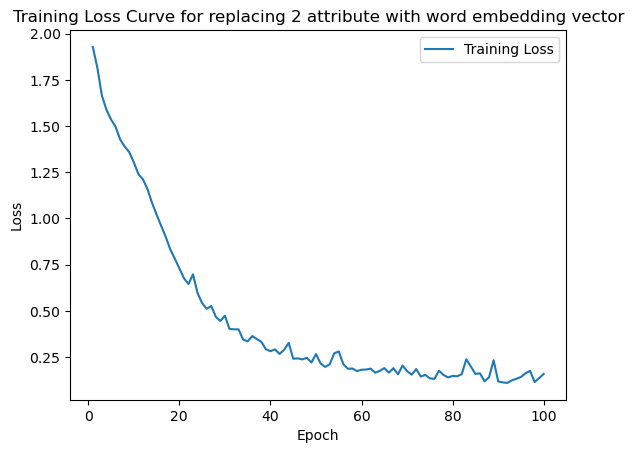


Test Accuracy: 0.9338

Classification Report:
              precision    recall  f1-score   support

           0     0.9821    0.9649    0.9735        57
           1     0.9600    0.8000    0.8727        60
           2     0.8088    0.9016    0.8527        61
           3     0.9038    0.9216    0.9126        51
           4     0.9429    0.9706    0.9565        68
           5     0.9643    0.9643    0.9643        56
           6     0.9859    1.0000    0.9929        70

    accuracy                         0.9338       423
   macro avg     0.9354    0.9319    0.9322       423
weighted avg     0.9365    0.9338    0.9337       423



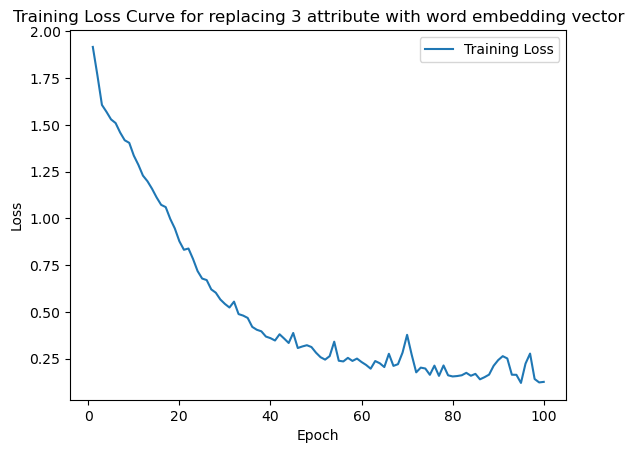


Test Accuracy: 0.9078

Classification Report:
              precision    recall  f1-score   support

           0     0.8116    0.9825    0.8889        57
           1     0.8214    0.7667    0.7931        60
           2     0.9091    0.8197    0.8621        61
           3     0.9038    0.9216    0.9126        51
           4     0.9286    0.9559    0.9420        68
           5     1.0000    0.8929    0.9434        56
           6     0.9859    1.0000    0.9929        70

    accuracy                         0.9078       423
   macro avg     0.9086    0.9056    0.9050       423
weighted avg     0.9108    0.9078    0.9073       423



In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from artificial_nn import ANN
from util import preprocess
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
columns_to_use = ['Weight','Height','Gender','Age','CALC','FAVC','FCVC','MTRANS','NObeyesdad']

extracted_df = data[columns_to_use]

feature_mapping = {'Insufficient_Weight': 0,'Normal_Weight': 1,'Overweight_Level_I': 2,'Overweight_Level_II': 3,'Obesity_Type_I': 4,'Obesity_Type_II': 5,'Obesity_Type_III': 6}

suitable_one_hot_encoded_columns = ['Gender','CALC','MTRANS','FAVC']
suitable_word_embedded_columns = [['Gender'],['Gender','MTRANS'],['Gender','MTRANS','CALC']]

for word_embedded_columns in suitable_word_embedded_columns:

    # because we word embedded the columns we dont need to one hot encode them
    one_hot_encoded_columns = [col for col in suitable_one_hot_encoded_columns if col not in word_embedded_columns]

    df_encoded_onehot = preprocess.one_hot_encode(extracted_df, one_hot_encoded_columns)
    
    # Reinsert the column at the end
    preprocess.put_the_column_at_end(df_encoded_onehot,"NObeyesdad")
    
    df_encoded_onehot['NObeyesdad'] = df_encoded_onehot['NObeyesdad'].map(feature_mapping)
    
    # Features : X , Labels : y
    X, y = preprocess.sep_column(df_encoded_onehot, "NObeyesdad")
    
    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=462)
    
    column_to_be_normalized = ['Age','Height','Weight','FCVC']
    
    preprocess.min_max_norm([X_train, X_test],column_to_be_normalized, X_train.min(), X_train.max())
    
    
    X_train = preprocess.replace_with_word_embeddings(X_train, word_embeddings, word_embedded_columns)
    X_test = preprocess.replace_with_word_embeddings(X_test, word_embeddings, word_embedded_columns)
    
    #print(X_train)
    
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
    X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values)
    y_test_tensor = torch.tensor(y_test.values)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    input_size = X_train_tensor.shape[1]
    # TODO - I think hidden layer sizes are too small w.r.t. input size
    hidden_sizes = [64,64,64]               # hidden layer size is hyperparameter
    output_size = len(y.unique())
    
    model = ANN.ArtificialNeuralNetwork(input_size, hidden_sizes, output_size)
    
    criterion = nn.CrossEntropyLoss()                       # cross entropy value is used as loss function
    optimizer = optim.Adam(model.parameters(), lr=0.0010)    # learning rate is hyperparameter
    
    num_epochs = 100
    loss_list = []
    
    for epoch in range(num_epochs):
        loss_of_epoch = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()               # clears the gradients before new back prop (new batch)
            outputs = model.forward(inputs)     # feed model with forward prop (get predictions - outputs)
            loss = criterion(outputs, labels)   # calculate loss value of predictions
            loss.backward()                     # perform back prop to compute gradient w.r.t model params
            optimizer.step()                    # update the model params (weights) according to LR and gradient

            loss_of_epoch += loss.item()

        loss_list.append(loss_of_epoch / len(train_loader))
    
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.plot(range(1, num_epochs + 1), loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve for replacing {len(word_embedded_columns)} attribute with word embedding vector')
    plt.legend()
    plt.show()
    

    # evaluation of model in test set

    """
    Classification Report
    - precision = TP / (TP + FP)
    - recall = TP / (TP + FN)
    - f1-score = 2 * (precision * recall) / (precision + recall)
    - accuracy
    """
            
    with torch.no_grad():
        model.eval()
        outputs = model.forward(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted.cpu(), digits=4))